<a href="https://colab.research.google.com/github/siruku6/model_on_fer2013/blob/master/20220424_create_FER_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition

- Information on kaggle  
[Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/overview)
- Document for dataset  
[FER2013 Dataset](https://docs.activeloop.ai/datasets/fer2013-dataset)

## labels

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral



# 1. install modules

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

!pip install -q pytorch_lightning

# This is necessary for `torchvision.datasets.FER2013`
!pip install torchvision==0.12


env: CUBLAS_WORKSPACE_CONFIG=:4096:8
     |████████████████████████████████| 582 kB 5.4 MB/s 
     |████████████████████████████████| 136 kB 9.7 MB/s 
     |████████████████████████████████| 596 kB 29.2 MB/s 
     |████████████████████████████████| 408 kB 9.0 MB/s 
     |████████████████████████████████| 1.1 MB 26.6 MB/s 
     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 144 kB 27.8 MB/s 
     |████████████████████████████████| 271 kB 32.2 MB/s 
     |████████████████████████████████| 21.0 MB 9.6 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency re

In [2]:
!pip list | grep torchvision

torchvision                   0.12.0


In [3]:
from google.colab import files
import numpy as np
import pandas as pd
from tqdm import tqdm

# Treating images
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

# 2. load data & create dataset

torchvisionのFER2013管理モジュール

https://pytorch.org/vision/stable/generated/torchvision.datasets.FER2013.html

In [ ]:
dir(torchvision.datasets)

In [8]:
# uploaded = files.upload()

Saving train.csv.zip to train.csv.zip


In [5]:
!unzip "drive/MyDrive/Colab Notebooks/data/FER2013/train.csv.zip"
!mkdir fer2013
!mv train.csv fer2013/

Archive:  drive/MyDrive/Colab Notebooks/data/FER2013/train.csv.zip
  inflating: train.csv               


## normalizationのmean, stdの計算

In [30]:
transform = transforms.Compose([
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
pre_dataset = torchvision.datasets.FER2013('./', transform=transform)
pre_dataloader = torch.utils.data.DataLoader(pre_dataset, batch_size=40, shuffle=True, drop_last=True)


In [11]:
# https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/8
mean = 0.
meansq = 0.
for data, label in tqdm(pre_dataloader):
    mean = data.mean()
    meansq = (data**2).mean()

std = torch.sqrt(meansq - mean**2)
print("mean: " + str(mean))
print("std: " + str(std))
print()

100%|██████████| 717/717 [00:17<00:00, 40.53it/s]

mean: tensor(0.5039)
std: tensor(0.2480)



## Datasetの作成

In [6]:

transform = transforms.Compose([
    # TODO: training時のみこのtransformを適用したい
    #    要調査
    # https://medium.com/@reachraktim/emotion-recognition-on-the-fer-dataset-using-pytorch-835ce93d52a5
    transforms.RandomAffine(degrees=10),
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize((224, 224)),
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    # # PyTorch公式でもこのmean, stdが推奨されている -> 3 channels でないと使えないのでコメントアウト
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.4942], std=[0.2614])
])

dataset = torchvision.datasets.FER2013('./', transform=transform)
dataset

Dataset FER2013
    Number of datapoints: 28709
    Root location: ./
    split=train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-10.0, 10.0])
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.4942], std=[0.2614])
           )

In [13]:
dataset[0][0]

tensor([[[-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         ...,
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906],
         [-1.8906, -1.8906, -1.8906,  ..., -1.8906, -1.8906, -1.8906]]])

0


(-0.5, 223.5, 223.5, -0.5)

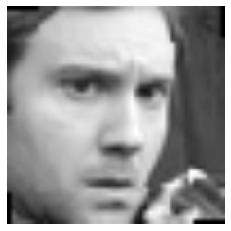

In [14]:
print(dataset[0][1])
plt.imshow(
    dataset[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

3


(-0.5, 223.5, 223.5, -0.5)

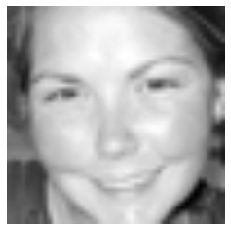

In [15]:
print(dataset[8][1])
plt.imshow(
    dataset[8][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

In [16]:
len(dataset)

28709

# 3. create dataloader

In [7]:
pl.seed_everything(0)

n_train = int(len(dataset) * 0.6)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

batch_size = 200
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader


Global seed set to 0


6


(-0.5, 223.5, 223.5, -0.5)

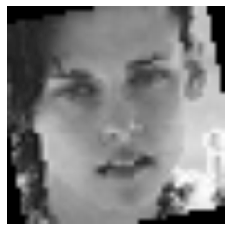

In [24]:
print(train[0][1])
plt.imshow(
    train[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

4


(-0.5, 223.5, 223.5, -0.5)

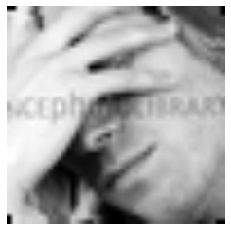

In [19]:
print(val[0][1])
plt.imshow(
    val[0][0].reshape(224, 224),
    interpolation='nearest',
    cmap = "gray",
)
plt.axis('off')

# 4. ネットワーク構築

## ネットワーク構成要素の動作確認

In [15]:
feature = resnet18(pretrained=True)
feature

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# test動作確認
conv = nn.Conv2d(1, 3, 1, 1, (0, 0))
fc = nn.Linear(1000, 7)

h0 = conv(dataset[0][0].unsqueeze(0))
print("h0.shape: ", h0.shape)

h1 = feature(h0)
print("h0.shape: ", h1.shape)

h2 = fc(h1)
print("h0.shape: ", h2.shape)


h0.shape:  torch.Size([1, 3, 224, 224])
h0.shape:  torch.Size([1, 1000])
h0.shape:  torch.Size([1, 7])


## ネットワーク構築

In [14]:
class ClassifyFacialExpressionNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 3, 1, 1, (0, 0))
        self.resnet = resnet18(pretrained=True)
        self.fc = nn.Linear(1000, 7)

    def forward(self, x):
        h0 = self.conv(x)
        h1 = self.resnet(h0)
        h2 = self.fc(h1)
        return h2

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.01)
        return optimizer


# 5. 学習

## 学習実施

In [ ]:
torch.cuda.empty_cache()

gpu_on: bool = torch.cuda.is_available()
gpus: int = 1 if gpu_on else 0
gpus

pl.seed_everything(0)
c_net = ClassifyFacialExpressionNet()
logger = CSVLogger(save_dir='logs', name='facial_net')
trainer = pl.Trainer(max_epochs=10, gpus=gpus, deterministic=True, logger=logger)
trainer.fit(c_net, train_loader, val_loader)


In [9]:
trainer.callback_metrics

{'train_acc': tensor(0.7159),
 'train_loss': tensor(0.7840),
 'val_acc': tensor(0.5995),
 'val_loss': tensor(1.1192)}

## 学習結果確認

In [10]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/facial_net/version_0/checkpoints/epoch=9-step=860.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/facial_net/version_0/checkpoints/epoch=9-step=860.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5735714435577393
        test_loss            1.188377857208252
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5735714435577393, 'test_loss': 1.188377857208252}]

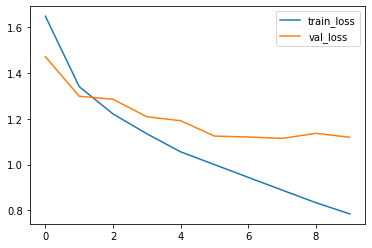

In [12]:
# 結果確認
log = pd.read_csv('logs/facial_net/version_0/metrics.csv')

log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

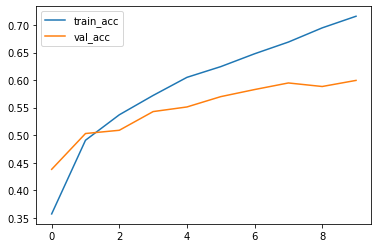

In [13]:
log[['train_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc'].plot()
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot()
plt.legend()

# 6. ResNetの1層目を追加するのではなく、書き換えた場合、精度はどうなるか

https://discuss.pytorch.org/t/modify-resnet-or-vgg-for-single-channel-grayscale/22762/10